In [1]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import os
import time
import argparse
import datetime
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.utils import accuracy, AverageMeter
import matplotlib.pyplot as plt
from timm.scheduler.scheduler import Scheduler
from train_test import train,test
from helpers import get_data_loader
from model import ViT
from helpers import load_checkpoint

In [2]:
torch.manual_seed(42)

In [3]:
train_loader,test_loader = get_data_loader(3000,2,"datasets/cifar-100/cifar-100-python",download=False)


In [ ]:
# torch.norm(student_model.transformer.layers[0].weight).item()

Epoch 1/100, Loss: 4.398589807398179
Current Learning Rate: 9.997532801828658e-05
accuracy: 6.0%
max_accuracy : 6.0
Epoch 2/100, Loss: 4.053728594499476
Current Learning Rate: 9.990133642141359e-05
accuracy: 9.7%
max_accuracy : 9.7
Epoch 3/100, Loss: 3.854908452314489
Current Learning Rate: 9.977809823015401e-05
accuracy: 12.45%
max_accuracy : 12.45
Epoch 4/100, Loss: 3.720091511221493
Current Learning Rate: 9.960573506572391e-05
accuracy: 15.0%
max_accuracy : 15.0
Epoch 5/100, Loss: 3.617290693170884
Current Learning Rate: 9.93844170297569e-05
accuracy: 15.6%
max_accuracy : 15.6
Epoch 6/100, Loss: 3.5210994411917294
Current Learning Rate: 9.911436253643445e-05
accuracy: 17.9%
max_accuracy : 17.9
Epoch 7/100, Loss: 3.441144157858456
Current Learning Rate: 9.879583809693738e-05
accuracy: 18.85%
max_accuracy : 18.85
Epoch 8/100, Loss: 3.3619202585781323
Current Learning Rate: 9.842915805643157e-05
accuracy: 19.85%
max_accuracy : 19.85
Epoch 9/100, Loss: 3.2967784264508415
Current Learnin

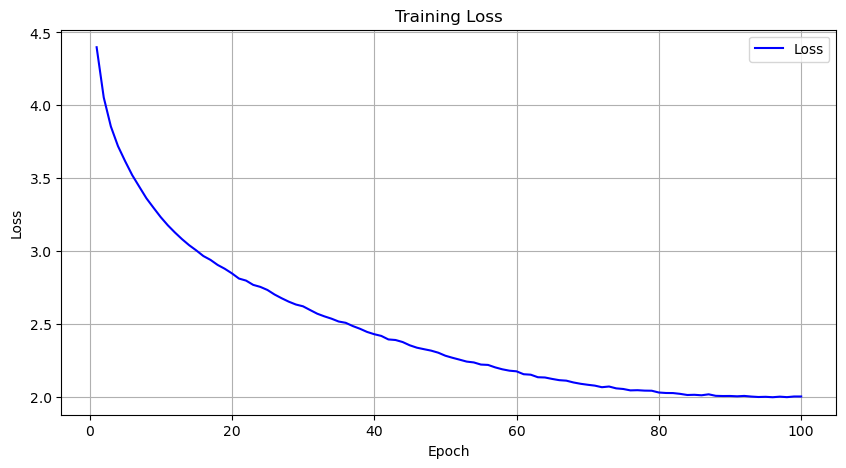

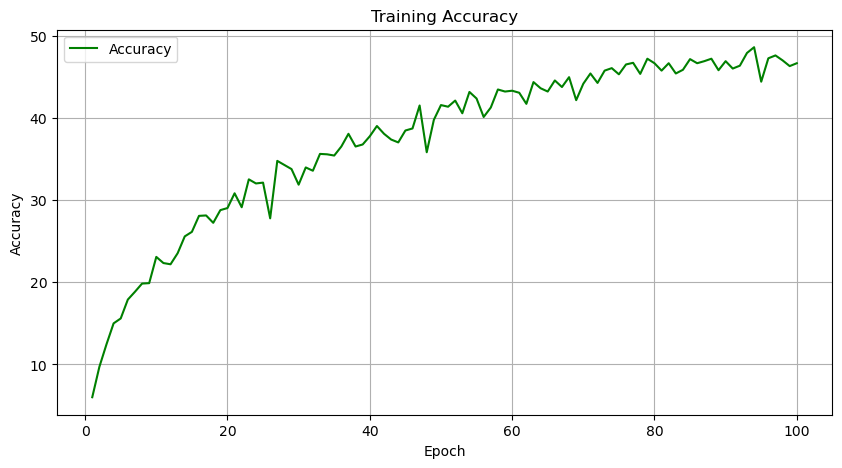

In [4]:
teacher_model = ViT(
    image_size=224,
    patch_size=16,
    num_classes=100,
    dim=768,
    depth=7,
    heads=12,
    mlp_dim=512,
    dropout=0.1
).to("cuda")
teacher_save_path = "save_model/cifar-100/vit_16_teacher_cifar-100"

teacher_load_path = f"{teacher_save_path}/best_model.pt"
train(
    teacher_model,
    train_loader,
    test_loader,
    epochs=100,
    learning_rate=0.0001,
    device='cuda',
    save_path=teacher_save_path,
    # load_path=teacher_load_path
)

In [5]:
load_checkpoint(teacher_model,"save_model/cifar-100/vit_16_teacher_cifar-100/best_model.pt")
test(teacher_model,test_loader,device='cuda')

Test Accuracy: 36.34%


36.34

In [6]:
student_base_save_path = "save_model/cifar-100/vit_16_student_base_cifar-100"
student_base_model = ViT(
    image_size=224,
    patch_size=16,
    num_classes=100,
    dim=768,
    depth=6,
    heads=6,
    mlp_dim=512,
    dropout=0.1
).to("cuda")

train(
    student_base_model,
    train_loader,
    test_loader,
    epochs=100,
    learning_rate=0.0001,
    device='cuda',
    save_path=student_base_save_path,
)

Epoch 1/100, Loss: 4.45923199373133
Current Learning Rate: 9.997532801828658e-05
accuracy: 5.9%
max_accuracy : 5.9
Epoch 2/100, Loss: 4.1349805944106155
Current Learning Rate: 9.990133642141359e-05
accuracy: 9.0%
max_accuracy : 9.0
Epoch 3/100, Loss: 3.9226456249461457
Current Learning Rate: 9.977809823015401e-05
accuracy: 11.95%
max_accuracy : 11.95
Epoch 4/100, Loss: 3.786898178212783
Current Learning Rate: 9.960573506572391e-05
accuracy: 13.1%
max_accuracy : 13.1
Epoch 5/100, Loss: 3.6893402688643513
Current Learning Rate: 9.93844170297569e-05
accuracy: 14.8%
max_accuracy : 14.8
Epoch 6/100, Loss: 3.607893845614265
Current Learning Rate: 9.911436253643445e-05
accuracy: 16.45%
max_accuracy : 16.45
Epoch 7/100, Loss: 3.528994462069343
Current Learning Rate: 9.879583809693738e-05
accuracy: 16.1%
Epoch 8/100, Loss: 3.4639982475953945
Current Learning Rate: 9.842915805643157e-05
accuracy: 19.15%
max_accuracy : 19.15
Epoch 9/100, Loss: 3.404946383307962
Current Learning Rate: 9.8014684283

RuntimeError: Parent directory save_model/cifar-100/vit_16_student_base_cifar-100 does not exist.

In [ ]:
load_checkpoint(student_base_model,"save_model/cifar-100/vit_16_student_base_cifar-100/best_model.pt")
test(student_base_model,test_loader)

In [ ]:
student_kd_save_path = "save_model/cifar-100/vit_16_student_kd_cifar-100"
student_kd = ViT(
    image_size=224,
    patch_size=16,
    num_classes=100,
    dim=768,
    depth=6,
    heads=6,
    mlp_dim=512,
    dropout=0.1
).to("cuda")

teacher_load_path = f"{teacher_save_path}/best_model.pt"

train_kd(
    student_kd,
    teacher_model,
    train_loader,
    test_loader,
    T=2,
    soft_target_loss_weight=0.3,
    ce_loss_weight=0.7,
    epochs=100,
    learning_rate=0.0001,
    save_path=student_kd_save_path,
    load_path_teacher=teacher_load_path,
)

In [ ]:
load_checkpoint(student_kd,"save_model/cifar-100/vit_16_student_kd_cifar-100/best_model.pt")
test(student_kd,test_loader)

In [ ]:
model_size_bytes = sum(param.numel() for param in student_kd.parameters() if param.requires_grad)

In [ ]:
for name, layer in model.named_children():
    print(name)

In [ ]:
module = model.transformer.layers[0]

In [ ]:
attention = module[0].fn

In [ ]:
print(list(attention.named_parameters()))

In [ ]:
linear_layer = attention.to_qkv

In [ ]:
linear_layer

In [ ]:
prune.random_unstructured(linear_layer, name="weight", amount=0.3)

In [ ]:
model.transformer.layers[0][0].fn.to_qkv.weight